<a href="https://colab.research.google.com/github/LaXnZ/enhancing-sbmm-in-competitive-games/blob/prototype-v1/SBMM_Prototype_V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Team 1:
     Player  SkillRating
0  Player68     0.860783
1  Player22     0.533104
2  Player49     0.026234
3  Player38     0.781405
4  Player97     0.052538

Team 2:
      Player  SkillRating
0   Player98     0.014025
1   Player47     0.656260
2  Player136     0.035489
3   Player51     0.915073
4   Player93     0.738337

Team 1 Total Skill: 2.2540638003451283
Team 2 Total Skill: 2.359184652100536

Fairness (Skill Difference): 0.10512085175540786

Precision (Balance of the teams): 0.9 - Highly Balanced


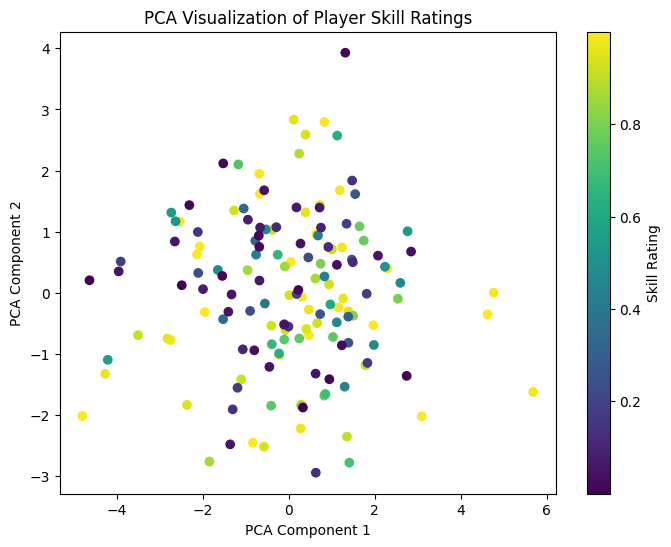

In [6]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
import random

# Suppressing the warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1. **Load the saved model**
model_path = '/content/drive/MyDrive/Final Year Project - APIIT/Models/logistic_regression_model.pkl'
model = joblib.load(model_path)

# 2. **Load the saved testing dataset**
test_data_path = '/content/drive/MyDrive/Final Year Project - APIIT/Datasets/testing_data.csv'
test_data = pd.read_csv(test_data_path)

# 3. **Add a 'Player' column to represent players by their index**
test_data['Player'] = ['Player' + str(i) for i in range(1, len(test_data) + 1)]

# 4. **Prepare the features and target**
X_test = test_data.drop(columns=['Target', 'Player'])  # Features (drop 'Target' and 'Player')
y_test = test_data['Target']  # Target

# Make predictions using the loaded model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# 5. **Simulate 5v5 matchmaking**
# Sorting players based on their skill ratings (using the probabilities as skill scores)
test_data['SkillRating'] = y_prob
df_sorted = test_data.sort_values(by='SkillRating', ascending=False)

# Randomly shuffle the players each time to form different teams
players = df_sorted[['Player', 'SkillRating']].values.tolist()
random.shuffle(players)

# Divide players into two teams (5v5)
team1 = players[:5]
team2 = players[5:10]

# 6. **Display Team Information**
print("Team 1:")
team1_df = pd.DataFrame(team1, columns=['Player', 'SkillRating'])
print(team1_df)  # Display Player and SkillRating columns
print("\nTeam 2:")
team2_df = pd.DataFrame(team2, columns=['Player', 'SkillRating'])
print(team2_df)  # Display Player and SkillRating columns

# Calculate total skill for both teams
total_team1_skill = sum([player[1] for player in team1])
total_team2_skill = sum([player[1] for player in team2])

print("\nTeam 1 Total Skill:", total_team1_skill)
print("Team 2 Total Skill:", total_team2_skill)

# 7. **Evaluate fairness (skill difference between teams)**
fairness = abs(total_team1_skill - total_team2_skill)
print(f"\nFairness (Skill Difference): {fairness}")

# 8. **Precision (Balance) Calculation**
# Precision: Balance between team skill levels
# Lower skill difference = better precision (1 / (1 + fairness))
precision = 1 / (1 + fairness)  # A value closer to 1 means more balance
precision_score = round(precision, 2)  # Round it for better presentation

# Interpretation of balance
if precision_score > 0.8:
    balance_interpretation = "Highly Balanced"
elif precision_score > 0.5:
    balance_interpretation = "Moderately Balanced"
else:
    balance_interpretation = "Imbalanced"

# Display the Precision in a more readable way
print(f"\nPrecision (Balance of the teams): {precision_score} - {balance_interpretation}")

# 9. **Generate PCA visualization of player skill levels**
X_scaled = StandardScaler().fit_transform(X_test)  # Standardize the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to the dataframe for visualization
df_sorted['PCA1'] = X_pca[:, 0]
df_sorted['PCA2'] = X_pca[:, 1]

# Plot PCA
plt.figure(figsize=(8, 6))
plt.scatter(df_sorted['PCA1'], df_sorted['PCA2'], c=df_sorted['SkillRating'], cmap='viridis')
plt.colorbar(label='Skill Rating')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Player Skill Ratings')
plt.show()